# <center>**Milestone 2**<center>

## **Import**

In [91]:
import os
import json
import gc
import csv
import pickle
import sys
import random
import glob
import pandas as pd
import matplotlib.pyplot as plt
import math

from pathlib import Path
from tqdm import tqdm
from __future__ import annotations
from collections import defaultdict

from my_scanner import *
from my_parser import *
from my_matcher import *
from my_featureEngineering import *
from my_modeling import *
from my_evaluation import *

## **Configuration**


In [92]:
RAW_ROOT = "../30-paper"
USING_SHA256_HASH = False

# 1. Output directory
OUTPUT_DIR = "23127453"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Configuration for caching
CACHE_DIR = ".cache"
os.makedirs(CACHE_DIR, exist_ok=True)
sys.setrecursionlimit(20000)

MANUAL_DIR = "manual_labeling"
os.makedirs(MANUAL_DIR, exist_ok=True)

random.seed(42)

## **Dataset rescan**


In [93]:
scan_result = scan_dataset(RAW_ROOT)

for k, v in scan_result.items():
    print(k, v["status"], v["versions"])

2211-13747 NO_TEX []
2211-13748 READY ['2211-13748v1']
2211-13749 READY ['2211-13749v1']
2211-13750 READY ['2211-13750v1', '2211-13750v2']
2211-13751 READY ['2211-13751v1']
2211-13752 READY ['2211-13752v1']
2211-13753 READY ['2211-13753v1']
2211-13754 READY ['2211-13754v1']
2211-13755 READY ['2211-13755v1', '2211-13755v2']
2211-13756 READY ['2211-13756v1', '2211-13756v2']
2211-13757 READY ['2211-13757v1', '2211-13757v2']
2211-13758 READY ['2211-13758v1']
2211-13759 READY ['2211-13759v1', '2211-13759v2']
2211-13760 READY ['2211-13760v1', '2211-13760v2']
2211-13761 READY ['2211-13761v1']
2211-13762 READY ['2211-13762v1', '2211-13762v2']
2211-13763 READY ['2211-13763v1']
2211-13764 READY ['2211-13764v1']
2211-13765 READY ['2211-13765v1']
2211-13766 READY ['2211-13766v1', '2211-13766v2', '2211-13766v3']
2211-13767 READY ['2211-13767v1']
2211-13768 READY ['2211-13768v1', '2211-13768v2']
2211-13769 READY ['2211-13769v1', '2211-13769v2']
2211-13770 READY ['2211-13770v1']
2211-13771 READY ['22

## **Version-level Multi-file Resolver**


In [94]:
pub_results = []

ready_items = [
    (pub_id, info)
    for pub_id, info in scan_result.items()
    if info["status"] == "READY"
]

for pub_id, info in tqdm(ready_items, desc="Publications"):
    for version in info["versions"]:
        version_path = f"{RAW_ROOT}/{pub_id}/tex/{version}"

        result = resolve_version(
            publication_id=pub_id,
            version_name=version,
            version_path=version_path
        )

        pub_results.append(result)

# Xem kết quả
for r in pub_results:
    print(r["publication_id"], r["version"], r["used_tex_files"])


Publications: 100%|██████████| 94/94 [00:15<00:00,  5.98it/s]

2211-13748 2211-13748v1 ['weibo.tex']
2211-13749 2211-13749v1 ['On_projections_of_tailsvA.tex']
2211-13750 2211-13750v1 ['comparingsinglettestingschemes.tex']
2211-13750 2211-13750v2 ['comparingsinglettestingschemes4.tex']
2211-13751 2211-13751v1 ['Kane_et_al_JFM_v1.tex']
2211-13752 2211-13752v1 ['main.tex', 'macros.tex', '00_abstract.tex', '01_intro.tex', '02_related.tex', '03_method.tex', '04_results.tex', '05_conclusion.tex', '07_acc.tex', '06_appendix.tex']
2211-13753 2211-13753v1 ['0-title.tex']
2211-13754 2211-13754v1 ['main.tex']
2211-13755 2211-13755v1 ['main.tex']
2211-13755 2211-13755v2 ['main.tex']
2211-13756 2211-13756v1 ['main.tex']
2211-13756 2211-13756v2 ['main.tex']
2211-13757 2211-13757v1 ['main.tex']
2211-13757 2211-13757v2 ['main.tex']
2211-13758 2211-13758v1 ['main.tex']
2211-13759 2211-13759v1 ['main.tex']
2211-13759 2211-13759v2 ['main.tex']
2211-13760 2211-13760v1 ['main.tex']
2211-13760 2211-13760v2 ['main.tex']
2211-13761 2211-13761v1 ['main.tex']
2211-13762 22

## **LaTeX Hierarchy Parser**

We parsed each LaTeX version into a hierarchical tree structure. Sectioning commands were treated as internal nodes, while only sentences, tables, and figures were considered leaf nodes, strictly following the seminar constraints. No deduplication or identifier assignment was performed at this stage.


In [95]:
def save_tree_to_cache(pub_id: str, version: str, root: FileNode) -> str:
    """
    Serialize tree to disk and return cache path.
    Returns the cache file path for later retrieval.
    """
    cache_path = os.path.join(CACHE_DIR, f"{pub_id}_{version}.pkl")
    with open(cache_path, "wb") as f:
        pickle.dump(root, f, protocol=4)
    return cache_path

def load_tree_from_cache(cache_path: str) -> FileNode:
    """Load tree from cache file."""
    with open(cache_path, "rb") as f:
        return pickle.load(f)

In [96]:
parsed_versions = []


for version_info in tqdm(
    pub_results,
    desc="Parsing LaTeX versions",
    unit="version(s)"
):
    if version_info["status"] != "RESOLVED":
        continue

    version_path = (
        f"{RAW_ROOT}/"
        f"{version_info['publication_id']}/tex/"
        f"{version_info['version']}"
    )

    try:
        root_node = parse_tex_files(
            version_path=version_path,
            tex_files=version_info["used_tex_files"]
        )

        # Save to disk instead of keeping in memory
        cache_path = save_tree_to_cache(
            pub_id=version_info["publication_id"],
            version=version_info["version"],
            root=root_node
        )

        parsed_versions.append({
            "publication_id": version_info["publication_id"],
            "version": version_info["version"],
            "cache_path": cache_path,  # Store path, not tree
            "root": None  # Placeholder
        })

        # Explicitly free memory
        del root_node
        gc.collect()

    except Exception as e:
        print(
            f"[ERROR] {version_info['publication_id']} "
            f"{version_info['version']}: {e}"
        )

Parsing LaTeX versions: 100%|██████████| 140/140 [01:28<00:00,  1.58version(s)/s]


## **Deduplication & ID Assignment**

In [97]:
"""
STEP 3 - Deduplication & Merge trees per publication

Input:
    parsed_versions: list of {
        publication_id,
        version,
        root (hierarchy tree)
    }

Output:
    final_trees: dict[publication_id] -> merged root tree
"""

# Group trees by publication_id
pub_groups = defaultdict(list)
for item in parsed_versions:
    pub_groups[item["publication_id"]].append(item)

final_trees = {}

for pub_id, versions in tqdm(pub_groups.items(), desc="Deduplicating", unit="publication(s)"):
    if not versions:
        continue
    
    final_trees[pub_id] = {}
    # Sort versions
    versions.sort(key=lambda x: int(x["version"].split("v")[-1]) if "v" in x["version"] else 0)

    # Load Base Tree
    base_info = versions[0]
    with open(base_info["cache_path"], "rb") as f:
        base_root = pickle.load(f)

    # Normalize Base
    fast_normalize_and_id(base_root, base_info["version"])
    
    if len(versions) > 1:
        content_index = {}
        deduplicate_tree(base_root, content_index)
        final_trees[pub_id][base_info['version']] = base_root
        
        for v_info in versions[1:]:
            # Normalize Base
            with open(v_info["cache_path"], "rb") as f:
                root = pickle.load(f)
            fast_normalize_and_id(root, base_info["version"])
            deduplicate_tree(root, content_index)

            final_trees[pub_id][v_info['version']] = base_root
    
    else:
        final_trees[pub_id][base_info['version']] = base_root
    
    # Periodic GC to prevent memory fragmentation on large datasets
    if len(final_trees) % 50 == 0:
        gc.collect()

print(f"DONE: merged {len(final_trees)} publications")

Deduplicating: 100%|██████████| 94/94 [00:14<00:00,  6.69publication(s)/s]

DONE: merged 94 publications


In [98]:
# Example: Inspect one of the final trees
sample_pub = next(iter(final_trees))
sample_tree = next(iter(final_trees[sample_pub]))
root = final_trees[sample_pub][sample_tree]

print("Sample publication:", sample_pub)
print("Root node type:", root.node_type)
print("Number of children:", len(root.children))

Sample publication: 2211-13748
Root node type: document
Number of children: 16


## **Export to JSON**

In [99]:
"""
Export Structured Publication JSON

Input:
    final_trees: dict[publication_id] -> root_node

Output:
    Student ID/
        <pub_id>/
            <pub_id>.json
            metadata.json
            references.json
        ...
"""

# Export statistics
export_count = 0
missing_metadata = []
missing_references = []

for pub_id, root in tqdm(final_trees.items(), desc="Exporting JSON", unit="pub"):
    
    # Create publication subdirectory
    pub_output_dir = os.path.join(OUTPUT_DIR, pub_id)
    os.makedirs(pub_output_dir, exist_ok=True)
    
    # Export Content Tree (Parsed Hierarchy)
    content_json = {
        "publication_id": pub_id,
        "content_tree": serialize_node(root)
    }
    
    content_path = os.path.join(pub_output_dir, f"{pub_id}.json")
    with open(content_path, "w", encoding="utf-8") as f:
        json.dump(content_json, f, ensure_ascii=False, indent=2)
    
    # Copy Metadata (Original from Semantic Scholar)
    raw_metadata_path = os.path.join(RAW_ROOT, pub_id, "metadata.json")
    metadata_path = os.path.join(pub_output_dir, "metadata.json")
    
    if os.path.exists(raw_metadata_path):
        with open(raw_metadata_path, "r", encoding="utf-8") as f:
            metadata = json.load(f)
        with open(metadata_path, "w", encoding="utf-8") as f:
            json.dump(metadata, f, ensure_ascii=False, indent=2)
    else:
        missing_metadata.append(pub_id)
    
    # Copy References (Original from Semantic Scholar)
    raw_references_path = os.path.join(RAW_ROOT, pub_id, "references.json")
    references_path = os.path.join(pub_output_dir, "references.json")
    
    if os.path.exists(raw_references_path):
        with open(raw_references_path, "r", encoding="utf-8") as f:
            references = json.load(f)
        with open(references_path, "w", encoding="utf-8") as f:
            json.dump(references, f, ensure_ascii=False, indent=2)
    else:
        missing_references.append(pub_id)
    
    export_count += 1

print(f"Exported {export_count} publications to: {OUTPUT_DIR}")

if missing_metadata:
    print(f"\nWARNING: {len(missing_metadata)} publication(s) missing metadata.json")
    print(f"   {', '.join(missing_metadata[:5])}" + (" ..." if len(missing_metadata) > 5 else ""))

if missing_references:
    print(f"\nWARNING: {len(missing_references)} publication(s) missing references.json")
    print(f"   {', '.join(missing_references[:5])}" + (" ..." if len(missing_references) > 5 else ""))

Exporting JSON: 100%|██████████| 94/94 [00:04<00:00, 19.63pub/s]

Exported 94 publications to: 23127453


## **Extract References**

### Goal

Batch process publications to **extract**, **deduplicate**, and **export** references into standardized `.bib` files while maintaining a global key mapping.

### Workflow

1. **Iterate through pub_results**
* Skip entries where `status == "NO_TEX"` or the directory is missing.
* Identify target files (`.bib`, `.bbl`, `.tex`) in the version path.


2. **Extract & Deduplicate**
* Execute `extract_references_from_tex_files()` to gather `local_raw_refs`.
* Apply `deduplicate_references_with_mapping()` to produce `local_dedup_list` and `local_key_map`.


3. **ID Assignment & Export**
* Assign a unique `ref_id` to each entry via `generate_semantic_id()`.
* Write formatted entries to `OUTPUT_DIR/<pub_id>/refs.bib` using `export_to_bibtex()`.


4. **State Management & Cleanup**
* Store results in `deduplicated_references` and update `global_key_mapping`.
* Track statistics (`total_raw_found`, `count_exported`, `extract_errors`).
* Trigger `gc.collect()` to optimize memory usage.

In [100]:

deduplicated_references = {}
global_key_mapping = {} 
global_used_ids = set() 

extract_errors = 0
count_exported = 0
total_raw_found = 0
processed_count = 0

for version_info in tqdm(pub_results, desc="Processing Pipeline", unit="pub"):
    
    if version_info.get("status") == "NO_TEX":
        continue

    pub_id = version_info["publication_id"]
    version = version_info["version"]
    version_path = f"{RAW_ROOT}/{pub_id}/tex/{version}"
    
    if not os.path.exists(version_path):
        continue

    try:
        all_files_in_dir = os.listdir(version_path)
        target_files = [
            f for f in all_files_in_dir 
            if f.lower().endswith(('.bib', '.bbl', '.tex'))
        ]
        
        local_raw_refs = extract_references_from_tex_files(
            version_path=version_path,
            tex_files=target_files 
        )
        
        if not local_raw_refs:
            continue
            
        total_raw_found += len(local_raw_refs)

        local_dedup_list, local_key_map = deduplicate_references_with_mapping(local_raw_refs)
        
        save_dir = os.path.join(OUTPUT_DIR, pub_id)
        os.makedirs(save_dir, exist_ok=True)
        output_path = os.path.join(save_dir, "refs.bib")
        
        try:
            with open(output_path, 'w', encoding='utf-8') as f:
                for ref in local_dedup_list:
                    ref['ref_id'] = generate_semantic_id(ref, global_used_ids)
                    
                    bib_string = export_to_bibtex(ref)
                    f.write(bib_string)
            
            count_exported += 1
        except Exception as e:
            print(f"[ERROR] Export failed for {pub_id}: {e}")

        deduplicated_references[pub_id] = local_dedup_list
        global_key_mapping.update(local_key_map)
        
    except Exception as e:
        extract_errors += 1

    if 'local_raw_refs' in locals():
        del local_raw_refs
    
    processed_count += 1
    if processed_count % 50 == 0:
        gc.collect()

gc.collect()

print(f"\nPipeline Complete!")
print(f"  - Total Raw Refs Processed: {total_raw_found}")
print(f"  - Publications with Refs: {len(deduplicated_references)}")
print(f"  - Exported .bib files: {count_exported}")
print(f"  - Extraction Errors: {extract_errors}")

Processing Pipeline: 100%|██████████| 140/140 [00:18<00:00,  7.60pub/s]


Pipeline Complete!
  - Total Raw Refs Processed: 73939
  - Publications with Refs: 82
  - Exported .bib files: 120
  - Extraction Errors: 0


## **Reference Cleaning**

### Goal
Build two cleaned datasets per publication:
- **`cleaned_bibtex`**: cleaned versions of deduplicated BibTeX references (while preserving key identifiers)
- **`cleaned_arxiv`**: cleaned arXiv reference metadata loaded from `references.json`

### Workflow
1. **Clean deduplicated BibTeX references**
   - For each `pub_id` in `deduplicated_references`:
     - Loop through its references and run `clean_bibtex_entry(ref)`
     - Preserve important identifiers from the original reference:
       - `ref_id`, `key`, `all_keys`
     - Collect successfully cleaned entries into `cleaned_bibtex[pub_id]`
     - Skip any reference that raises an exception (silent continue)

2. **Load and clean arXiv truth references (`references.json`)**
   - For each `pub_id` in `cleaned_bibtex`:
     - Look for `RAW_ROOT/<pub_id>/references.json`
     - If present:
       - Load the JSON dict `{arxiv_id: meta}`
       - Inject `meta["arxiv_id"] = arxiv_id`
       - Clean each record with `clean_arxiv_reference(meta)`
       - Store results in `cleaned_arxiv[pub_id]`
     - If missing: set `cleaned_arxiv[pub_id] = []`
     - If loading/cleaning fails: warn and fall back to an empty list

In [101]:
cleaned_bibtex = {}

for pub_id in tqdm(deduplicated_references.keys(), desc="Cleaning BibTeX", unit="pub"):
    cleaned_entries = []
    for ref in deduplicated_references[pub_id]:
        try:
            cleaned_ref = clean_bibtex_entry(ref)
            cleaned_ref['ref_id'] = ref.get('ref_id', '')
            cleaned_ref['key'] = ref.get('key', '')
            cleaned_ref['all_keys'] = ref.get('all_keys', [])
            
            cleaned_entries.append(cleaned_ref)
        except Exception as e:
            continue
            
    cleaned_bibtex[pub_id] = cleaned_entries

cleaned_arxiv = {}

for pub_id in tqdm(cleaned_bibtex.keys(), desc="Loading & Cleaning arXiv Truth", unit="pub"):
    ref_json_path = os.path.join(RAW_ROOT, pub_id, "references.json")
    
    if os.path.exists(ref_json_path):
        try:
            with open(ref_json_path, 'r', encoding='utf-8') as f:
                arxiv_raw = json.load(f)
            
            cleaned_entries = []
            for arxiv_id, meta in arxiv_raw.items():
                meta['arxiv_id'] = arxiv_id 
                cleaned_ref = clean_arxiv_reference(meta)
                cleaned_entries.append(cleaned_ref)
            
            cleaned_arxiv[pub_id] = cleaned_entries
        except Exception as e:
            print(f"[WARN] Error loading references.json for {pub_id}: {e}")
            cleaned_arxiv[pub_id] = []
    else:
        cleaned_arxiv[pub_id] = []

# Summary
total_bib = sum(len(x) for x in cleaned_bibtex.values())
total_arxiv = sum(len(x) for x in cleaned_arxiv.values())
print(f"\nDONE: {total_bib} cleaned BibTeX entries vs {total_arxiv} cleaned arXiv entries.")

Loading & Cleaning arXiv Truth: 100%|██████████| 82/82 [00:00<00:00, 126.58pub/s]


DONE: 66534 cleaned BibTeX entries vs 1544 cleaned arXiv entries.


## **Labeling & Dataset Construction**

### **Manual Labeling**

#### **Build Manual Pairs**

##### Goal
Create **manual labeling datasets** (JSON files) for a small set of publications by generating **BibTeX ↔ arXiv candidate pairs** with precomputed match scores—unless enough JSON files already exist.

##### Workflow
1. **Check whether manual-labeling files already exist**
   - If `MANUAL_DIR` exists, count `*.json` files inside it.
   - If there are **≥ 5 files**, reuse them (no regeneration).
   - If fewer than 5, mark `generated = False` to regenerate.

2. **Select candidate publications to label (only when regenerating)**
   - Loop through `cleaned_bibtex`:
     - Get corresponding `cleaned_arxiv[pub_id]`.
     - Skip papers where either side has **< 20 entries**.
   - For each BibTeX entry, call `find_best_match(bib, arxiv_entries, threshold=0.7)` and count how many matches exist.
   - Keep only publications with **≥ 20 potential matches** and store stats (`bib_count`, `arxiv_count`, `potential_matches`).

3. **Pick the final papers to generate tasks for**
   - Sort candidate publications by `potential_matches` descending.
   - Select **5 papers** using `candidate_papers[1:6]` (i.e., skipping the top 1 and taking the next 5).
   - Warn if fewer than 5 papers meet the criteria.

4. **Generate labeling tasks (pair candidates + scores)**
   - For each selected `pub_id`:
     - For every BibTeX entry, compute a match score against **every** arXiv entry using `compute_match_score(bib, arxiv)`.
     - Build a pair record containing:
       - `label` (empty, to be filled manually)
       - `score` (rounded)
       - BibTeX metadata (key/title/authors/year)
       - arXiv metadata (id/title/authors/year)
     - Sort candidates by `score` (descending) and add them to a global `tasks` list for that publication.

5. **Export to JSON**
   - Save all generated pairs to `MANUAL_DIR/<pub_id>.json`.
   - Print the file path and total number of pairs created.


In [102]:
generated = True

if os.path.exists(MANUAL_DIR):
    existing_files = glob.glob(os.path.join(MANUAL_DIR, "*.json"))
    
    if len(existing_files) >= 5:
        print(f"Found {len(existing_files)} file JSON in folder '{MANUAL_DIR}'")
    else:
        print(f"Folder exists but only has {len(existing_files)} files. Will regenerate")
        generated = False

if not generated:
    
    candidate_papers = []

    for pub_id, bib_entries in tqdm(cleaned_bibtex.items(), desc="Filtering Papers"):
        arxiv_entries = cleaned_arxiv.get(pub_id, [])
        
        if len(bib_entries) < 20 or len(arxiv_entries) < 20:
            continue

        potential_matches = 0
        for bib in bib_entries:
            match = find_best_match(bib, arxiv_entries, threshold=0.7) 
            if match:
                potential_matches += 1
            
        if potential_matches >= 20:
            candidate_papers.append({
                'pub_id': pub_id,
                'bib_count': len(bib_entries),
                'arxiv_count': len(arxiv_entries),
                'potential_matches': potential_matches
            })

    candidate_papers.sort(key=lambda x: x['potential_matches'], reverse=True)
    selected_papers = candidate_papers[1:6]

    if len(selected_papers) < 5:
        print(f"Only found {len(selected_papers)} papers meeting the criteria")

    os.makedirs(MANUAL_DIR, exist_ok=True)

    for paper in selected_papers:
        pub_id = paper['pub_id']
        bib_pool = cleaned_bibtex[pub_id]
        arxiv_pool = cleaned_arxiv[pub_id]
        
        tasks = []
        
        for bib in bib_pool:
            
            current_bib_candidates = []
            
            for arxiv in arxiv_pool:
                
                score = compute_match_score(bib, arxiv)
                
                pair_data = {
                    "label": '', 
                    "score": round(score, 4),
                    
                    # Info BibTeX (Source)
                    "bib_key": bib['key'],
                    "bib_title": bib.get('normalized_title', ''),
                    "bib_author": ", ".join(bib.get('normalized_authors', [])),
                    "bib_year": bib.get('normalized_year', ''),
                    
                    # Info ArXiv (Target)
                    "arxiv_id": arxiv['arxiv_id'],
                    "arxiv_title": arxiv.get('normalized_title', ''),
                    "arxiv_author": ", ".join(arxiv.get('normalized_authors', [])),
                    "arxiv_year": arxiv.get('normalized_year', '')
                }
                
                current_bib_candidates.append(pair_data)
            
            current_bib_candidates.sort(key=lambda x: x['score'], reverse=True)
            
            tasks.extend(current_bib_candidates)

        file_path = os.path.join(MANUAL_DIR, f"{pub_id}.json")
        with open(file_path, 'w', encoding='utf-8') as f:
            json.dump(tasks, f, indent=2, ensure_ascii=False)
            
        print(f"  -> Created: {file_path} (Total pairs: {len(tasks)})")

Found 5 file JSON in folder 'manual_labeling'


#### **Read Manual Pairs**

##### Goal
Load human-labeled JSON files from `manual_labeling/` and convert them into a structured dataset of **(BibTeX, arXiv-candidate) pairs** with **binary labels**:
- `label = 1` for the manually verified match
- `label = 0` for all other arXiv candidates (negatives)

##### Workflow
1. **Load manual labeling JSON files**
   - Collect all `manual_labeling/*.json`.
   - If none are found, raise an error.
   - For each file, infer `pub_id` from the filename and load `labeled_data`.

2. **Build lookup pools for the publication**
   - Retrieve `bib_pool` from `cleaned_bibtex[pub_id]` and `arxiv_pool` from `cleaned_arxiv[pub_id]`.
   - Build fast lookup dicts:
     - `bib_dict = {bib_key → bib_entry}`
     - `arxiv_dict = {arxiv_id → arxiv_entry}`

3. **Extract positive matches**
   - Scan `labeled_data` and keep only items with `label == 1`.
   - Store valid matches in `positive_matches` as `{bib_key: matched_arxiv_id}` (only if both IDs exist in current pools).

4. **Expand each positive match into one-vs-all labeled pairs**
   - For each `(bib_key → matched_arxiv_id)`:
     - Create a shared `base` row with cleaned BibTeX metadata (title/authors/year/ref_id/all_keys).
     - Loop through **every** `arxiv_entry` in `arxiv_pool` and create a pair:
       - If `arxiv_id == matched_arxiv_id` → `label = 1`, `pair_type = "manual_verified"`
       - Else → `label = 0`, `pair_type = "manual_negative"`
     - Append each pair row into `manual_pairs`.
   - Print per-publication stats: number of verified bib entries, and total pos/neg pairs generated.

5. **Initialize a helper structure**
   - Create `FIXED_MANUAL_DATA` as a dict keyed by each `pub_id` from the JSON filenames (empty nested dicts).

In [103]:
manual_pairs = []
json_files = glob.glob("manual_labeling/*.json")

if not json_files:
    raise FileNotFoundError("Not found any JSON files in folder 'manual_labeling'")

for file_path in json_files:
    filename = os.path.basename(file_path)
    pub_id = filename.replace(".json", "")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        labeled_data = json.load(f)
    
    bib_pool = cleaned_bibtex.get(pub_id, [])
    arxiv_pool = cleaned_arxiv.get(pub_id, [])
    
    bib_dict = {b['key']: b for b in bib_pool}
    arxiv_dict = {a['arxiv_id']: a for a in arxiv_pool}
    
    positive_matches = {}  # {bib_key: arxiv_id}
    
    for item in labeled_data:
        if item['label'] == 1:
            bib_key = item['bib_key']
            arxiv_id = item['arxiv_id']
            
            if bib_key in bib_dict and arxiv_id in arxiv_dict:
                positive_matches[bib_key] = arxiv_id
    
    count_pos = 0
    count_neg = 0
    
    for bib_key, matched_arxiv_id in positive_matches.items():
        bib_entry = bib_dict[bib_key]
        
        base = {
            'pub_id': pub_id,
            'bib_key': bib_key,
            'bib_ref_id': bib_entry.get('ref_id'),
            'all_keys': bib_entry.get('all_keys', []),
            'bib_title_clean': bib_entry.get('normalized_title'),
            'bib_authors_clean': ", ".join(bib_entry.get('normalized_authors', [])),
            'bib_author_tokens': str(bib_entry.get('author_tokens', [])),
            'bib_year': bib_entry.get('normalized_year'),
            'source': 'manual',
        }
        
        for arxiv_entry in arxiv_pool:
            arxiv_id = arxiv_entry['arxiv_id']
            
            # Xác định label
            if arxiv_id == matched_arxiv_id:
                label = 1
                pair_type = 'manual_verified'
                count_pos += 1
            else:
                label = 0
                pair_type = 'manual_negative'
                count_neg += 1
            
            row = base.copy()
            row.update({
                'candidate_arxiv_id': arxiv_id,
                'candidate_title_clean': arxiv_entry.get('normalized_title'),
                'candidate_authors_clean': ", ".join(arxiv_entry.get('normalized_authors', [])),
                'candidate_author_tokens': str(arxiv_entry.get('author_tokens', [])),
                'candidate_year': arxiv_entry.get('normalized_year'),
                'pair_type': pair_type,
                'label': label
            })
            
            manual_pairs.append(row)
    
    print(f"Loaded {pub_id}: {len(positive_matches)} bib entries → {count_pos} pos, {count_neg} neg pairs")

FIXED_MANUAL_DATA = {pid.replace(".json", ""): {} for pid in [os.path.basename(f) for f in json_files]}

print(f"\nTotal Manual Pairs Loaded: {len(manual_pairs)}")
print(f"Positive Labels (1): {len([p for p in manual_pairs if p['label'] == 1])}")
print(f"Negative Labels (0): {len([p for p in manual_pairs if p['label'] == 0])}")
print(f"Ratio (pos:neg): 1:{len([p for p in manual_pairs if p['label'] == 0]) / max(1, len([p for p in manual_pairs if p['label'] == 1])):.1f}")

Loaded 2211-13755: 33 bib entries → 33 pos, 1584 neg pairs
Loaded 2211-13757: 37 bib entries → 37 pos, 2035 neg pairs
Loaded 2211-13760: 22 bib entries → 22 pos, 1122 neg pairs
Loaded 2211-13766: 21 bib entries → 21 pos, 1008 neg pairs
Loaded 2211-13767: 23 bib entries → 23 pos, 1150 neg pairs

Total Manual Pairs Loaded: 7035
Positive Labels (1): 136
Negative Labels (0): 6899
Ratio (pos:neg): 1:50.7


### **Automatic Labeling**

#### Goal

Identify and select a **random 10% sample** of valid publications (excluding manually labeled ones) to generate **automatic labels** based on high-confidence matches.

#### Workflow

1. **Define Selection Criteria**
* Set matching confidence threshold: `POSITIVE_THRESHOLD = 0.85`.
* Set sampling target: `TARGET_PERCENTAGE = 10%`.


2. **Filter & Scan Candidates**
* Exclude publications already in `FIXED_MANUAL_DATA`.
* Perform a **Lightweight Scan**: Iterate through candidates and validate if they contain *at least one* reference match exceeding the threshold using `find_best_match()`.


3. **Random Sampling**
* Calculate the required `target_count` based on the valid population.
* Use `random.sample()` to pick `selected_pub_ids` for the automatic dataset generation phase.


4. **Cleanup**
* Trigger `gc.collect()` to free memory after the scanning process.

In [104]:
POSITIVE_THRESHOLD = 0.8
TARGET_PERCENTAGE = 0.10  # 10%

auto_candidate_ids = [p for p in scan_result.keys() if p not in FIXED_MANUAL_DATA]

valid_auto_pub_ids = []

for pub_id in tqdm(auto_candidate_ids, desc="Lightweight Scan"):
    bib_pool = cleaned_bibtex.get(pub_id, [])
    arxiv_pool = cleaned_arxiv.get(pub_id, [])
    
    if not bib_pool or not arxiv_pool:
        continue
        
    is_valid = False
    for bib in bib_pool:
        match = find_best_match(bib, arxiv_pool, threshold=POSITIVE_THRESHOLD)
        if match:
            is_valid = True
            break 
    
    if is_valid:
        valid_auto_pub_ids.append(pub_id)


target_count = math.ceil(len(auto_candidate_ids) * TARGET_PERCENTAGE)
selected_pub_ids = random.sample(valid_auto_pub_ids, min(len(valid_auto_pub_ids), target_count))

print(f"-> Selected {len(selected_pub_ids)} publications (Target {int(TARGET_PERCENTAGE*100)}%).")

gc.collect();

Lightweight Scan: 100%|██████████| 95/95 [00:03<00:00, 27.10it/s] 

-> Selected 10 publications (Target 10%).


### **Export CSV**

#### Goal

**Construct and export the final labeled dataset** to CSV by combining manually verified pairs with automatically generated high-confidence matches.

#### Workflow

1. **Initialize CSV Output**
* Define standard schema (`fieldnames`) covering metadata, tokens, and labels.
* Create `OUTPUT_CSV` and write the header.


2. **Write Manual Data**
* If `manual_pairs` exists, write these verified records directly to the CSV.
* Track `count_manual`.


3. **Generate & Write Auto Data**
* Iterate through `selected_pub_ids`.
* For each BibTeX entry:
* Identify the **best match** among candidates.
* **Labeling Strategy:** Assign `label=1` to the best candidate and `label=0` to all other candidates (creating negative samples).


* Write attributes (titles, authors, tokens, year) to CSV.


4. **Finalization**
* Periodically trigger `gc.collect()` to manage memory.
* Print summary statistics (`Total`, `Manual`, `Auto`) upon completion.

In [105]:
OUTPUT_CSV = "../src/labeled_dataset.csv"

total_written = 0
count_manual = 0
count_auto = 0

fieldnames = [
    'pub_id', 'bib_key', 'bib_ref_id', 'all_keys', 
    'bib_title_clean', 'bib_authors_clean', 'bib_author_tokens', 'bib_year',
    'candidate_arxiv_id', 'candidate_title_clean', 'candidate_authors_clean', 
    'candidate_author_tokens', 'candidate_year',
    'source', 'pair_type', 'label'
]

with open(OUTPUT_CSV, mode='w', encoding='utf-8', newline='') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    
    if 'manual_pairs' in locals() and manual_pairs:
        print(f"Writing {len(manual_pairs)} manual pairs...")
        for row in manual_pairs:
            writer.writerow(row)
            count_manual += 1
    else:
        print("[WARN] The variable 'manual_pairs' does not exist or is empty. Ignore the Manual section.")

    print(f"Processing {len(selected_pub_ids)} auto publications...")
    
    for pub_id in tqdm(selected_pub_ids, desc="Auto Generation"):
        bib_pool = cleaned_bibtex.get(pub_id, [])
        arxiv_pool = cleaned_arxiv.get(pub_id, [])
        
        for bib in bib_pool:
            
            best_score = -1.0
            best_arxiv_idx = -1
            
            for idx, arxiv in enumerate(arxiv_pool):
                match = find_best_match(bib, [arxiv], threshold=0.0)
                score = match[1] if match else 0.0
                
                if score > best_score:
                    best_score = score
                    best_arxiv_idx = idx
                
            base_row = {
                'pub_id': pub_id,
                'bib_key': bib.get('key'),
                'bib_ref_id': bib.get('ref_id'),
                'all_keys': list(bib.get('all_keys', [])),
                'bib_title_clean': bib.get('normalized_title'),
                'bib_authors_clean': ", ".join(bib.get('normalized_authors', [])),
                'bib_author_tokens': str(bib.get('author_tokens', [])),
                'bib_year': bib.get('normalized_year'),
                'source': 'automatic'
            }
            
            for idx, arxiv in enumerate(arxiv_pool):
                label = 1 if idx == best_arxiv_idx else 0
                pair_type = 'positive_auto' if label == 1 else 'negative_auto'
                
                row = base_row.copy()
                row.update({
                    'candidate_arxiv_id': arxiv.get('arxiv_id'),
                    'candidate_title_clean': arxiv.get('normalized_title'),
                    'candidate_authors_clean': ", ".join(arxiv.get('normalized_authors', [])),
                    'candidate_author_tokens': str(arxiv.get('author_tokens', [])),
                    'candidate_year': arxiv.get('normalized_year'),
                    'pair_type': pair_type,
                    'label': label
                })
                
                writer.writerow(row)
                count_auto += 1
        
        if count_auto % 1000 == 0:
            gc.collect()

total_written = count_manual + count_auto
print(f"\n{'='*60}")
print(f"DONE! File saved at: {OUTPUT_CSV}")
print(f"Total Rows: {total_written}")
print(f"  - Manual Pairs: {count_manual}")
print(f"  - Auto Pairs:   {count_auto}")

Writing 7035 manual pairs...
Processing 10 auto publications...


Auto Generation: 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]


DONE! File saved at: ../src/labeled_dataset.csv
Total Rows: 29899
  - Manual Pairs: 7035
  - Auto Pairs:   22864


## **Feature Engineering**

### Goal
Ensure the **labeled dataset** is available, then run **feature engineering** to transform raw pair data into model-ready features, and finally **save the featured dataset**.

### Workflow
1. **Load labeled dataset if not already in memory**
   - If `final_df` is `None`, load from `../src/labeled_dataset.csv`.
   - If the CSV does not exist, raise an error.

2. **Apply feature engineering**
   - Call `feature_engineering(final_df)` to compute matching-related features from the labeled pairs.
   - Store the result in `df_features`.

3. **Export the featured dataset**
   - Save `df_features` to `../src/featured_dataset.csv` (no index column).

In [106]:
# Load labeled dataset if not already in memory
print("final_df is None, loading from CSV...")
labeled_path = Path("../src/labeled_dataset.csv")
if not labeled_path.exists():
    raise FileNotFoundError(f"File not found: {labeled_path}")

final_df = pd.read_csv(labeled_path)
    

# Apply feature engineering
df_features = feature_engineering(final_df)

# Save featured dataset
featured_path = "../src/featured_dataset.csv"
df_features.to_csv(featured_path, index=False)

final_df is None, loading from CSV...


In [107]:
# Summary
print(f"{'='*60}")
print(f"Feature Engineering Complete")
print(f"{'='*60}")
print(f"  Total samples: {len(df_features)}")
print(f"  Features created: {len([c for c in df_features.columns if c not in ['label', 'pub_id', 'bib_key', 'candidate_arxiv_id', 'source']])}")
# Check for NaN/Inf
print(f"  NaN values: {df_features.isna().sum().sum()}")
print(f"  Inf values: {np.isinf(df_features.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  Saved to: {featured_path}")
print(f"{'='*60}")

# Show feature columns
print("\n Feature columns:")
for col in df_features.columns:
    print(f"   - {col}")
print("\n Sample of featured dataset:")
df_features.head()

Feature Engineering Complete
  Total samples: 29899
  Features created: 5
  NaN values: 0
  Inf values: 0
  Saved to: ../src/featured_dataset.csv

 Feature columns:
   - label
   - pub_id
   - bib_key
   - candidate_arxiv_id
   - source
   - Title_Soft_Jaccard
   - Title_Length_Diff
   - Author_Overlap_Score
   - Author_Levenshtein_Ratio
   - Year_Diff

 Sample of featured dataset:


,label,pub_id,bib_key,candidate_arxiv_id,source,Title_Soft_Jaccard,Title_Length_Diff,Author_Overlap_Score,Author_Levenshtein_Ratio,Year_Diff
0,0,2211-13755,zhong2018open,2203-11483,manual,0.153846,36,0.0,0.507594,4.0
1,0,2211-13755,zhong2018open,2203-02146,manual,0.181818,24,0.0,0.397661,4.0
2,0,2211-13755,zhong2018open,2108-10869,manual,0.166667,16,0.0,0.233410,3.0
3,0,2211-13755,zhong2018open,2108-05773,manual,0.153846,39,0.0,0.447958,3.0
4,0,2211-13755,zhong2018open,2104-04314,manual,0.166667,13,0.2,0.323810,3.0


## **Train/Valid/Test Split**

### Goal
Separate publications by labeling source (**manual vs automatic**), then split the full featured dataset into **train/validation/test** sets in a controlled way, and export each split to CSV.

### Workflow
1. **Collect publication IDs by labeling source**
   - Extract unique `pub_id`s where `source == "manual"` → `manual_pub_ids`
   - Extract unique `pub_id`s where `source == "automatic"` → `auto_pub_ids`
   - Print how many publications belong to each source group.

2. **Split the dataset into train/val/test**
   - Call `split_data(df_features, manual_pub_ids, auto_pub_ids)` to create:
     - `df_train`, `df_val`, `df_test`
   - (The function likely uses the pub_id groups to avoid leakage and control how manual/auto data is distributed.)

3. **Save each split**
   - Export to:
     - `../src/train_dataset.csv`
     - `../src/val_dataset.csv`
     - `../src/test_dataset.csv`
   - Save without the index column.

In [108]:
# Get paper IDs for manual and automatic sources
manual_pub_ids = df_features[df_features['source'] == 'manual']['pub_id'].unique().tolist()
auto_pub_ids = df_features[df_features['source'] == 'automatic']['pub_id'].unique().tolist()

print(f"Manual labeled publications: {len(manual_pub_ids)}")
print(f"Automatic labeled publications: {len(auto_pub_ids)}")

# Split data
df_train, df_val, df_test = split_data(df_features, manual_pub_ids=manual_pub_ids, auto_pub_ids=auto_pub_ids)

train_path = "../src/train_dataset.csv"
val_path = "../src/val_dataset.csv"
test_path = "../src/test_dataset.csv"
df_train.to_csv(train_path, index=False)
df_val.to_csv(val_path, index=False)
df_test.to_csv(test_path, index=False)

Manual labeled publications: 5
Automatic labeled publications: 10
Split summary:
  Train: 22171 rows, 11 publications
  Valid: 5985 rows, 2 publications
  Test:  1743 rows, 2 publications


## **Model Training**

### Goal
Train a **learning-to-rank model** (via `train_ranker`) to predict the correct arXiv match for each BibTeX entry, using selected engineered features and optional **negative sampling** to handle class imbalance.

### Workflow
1. **Initialize training configuration**
   - Enable negative sampling: `USE_NEGATIVE_SAMPLING = True`
   - Sampling parameters:
     - `K_NEGATIVES = 15`: number of negatives sampled per positive (or per query group, depending on implementation)
     - `HARD_RATIO = 0.6`: fraction of sampled negatives chosen as “hard” (high-score / more confusing negatives)

2. **Define and validate feature columns**
   - Specify `FEATURE_COLS` (title/author/year features).
   - Filter to keep only those actually present in `df_train` → `available_features`.
   - Set training target label: `TARGET = "label"`.

3. **Train the ranker**
   - Call `train_ranker(df_train, df_val, features=available_features, target=TARGET, ...)`
   - Pass negative sampling settings (`use_negative_sampling`, `k_negatives`, `hard_ratio`) to control training data construction.

4. **Save the trained model**
   - Persist the trained model to `../src/xgb_ranker.joblib` using `save_model(...)`.

In [109]:
print(f"\n{'='*60}")
print(f"Starting Model Training")
print(f"{'='*60}")

USE_NEGATIVE_SAMPLING = True

K_NEGATIVES = 15

HARD_RATIO = 0.6

# Define feature columns
FEATURE_COLS = [
    # Title features
    "Title_Soft_Jaccard",
    "Title_Length_Diff",
    # Author features
    "Author_Overlap_Score",
    "Author_Levenshtein_Ratio",
    # Year features
    "Year_Diff"
]

# Get available features in the DataFrame
available_features = [f for f in FEATURE_COLS if f in df_train.columns]
print(f"Using {len(available_features)} features: {available_features}")

TARGET = "label"

# Check data imbalance before sampling
print(f"\nData imbalance BEFORE sampling:")
print(f"  Positives: {len(df_train[df_train[TARGET]==1])}")
print(f"  Negatives: {len(df_train[df_train[TARGET]==0])}")
print(f"  Ratio (pos:neg): 1:{len(df_train[df_train[TARGET]==0])/max(1, len(df_train[df_train[TARGET]==1])):.1f}")

# Train with configured negative sampling
model = train_ranker(
    df_train, 
    df_val, 
    features=available_features, 
    target=TARGET,
    use_negative_sampling=USE_NEGATIVE_SAMPLING,
    k_negatives=K_NEGATIVES,
    hard_ratio=HARD_RATIO
)

# Save model
model_path = save_model(model, "../src", filename="xgb_ranker.joblib")

print(f"\n{'='*60}")
print(f"Training Complete")


Starting Model Training
Using 5 features: ['Title_Soft_Jaccard', 'Title_Length_Diff', 'Author_Overlap_Score', 'Author_Levenshtein_Ratio', 'Year_Diff']

Data imbalance BEFORE sampling:
  Positives: 947
  Negatives: 21224
  Ratio (pos:neg): 1:22.4

Applying negative sampling to training data...

Negative Sampling Summary:
  Original: 22171 rows
  Sampled:  10582 rows
  Reduction: 52.3%
  Positives: 947
  Negatives: 9635
  Ratio (pos:neg): 1:10.2
Best iteration: 11
Best score: 0.7385407993539469
Model saved to: ../src\xgb_ranker.joblib

Training Complete



Feature Importance:


,feature,importance
3,Author_Levenshtein_Ratio,0.559681
0,Title_Soft_Jaccard,0.188750
2,Author_Overlap_Score,0.117087
4,Year_Diff,0.068390
1,Title_Length_Diff,0.066093


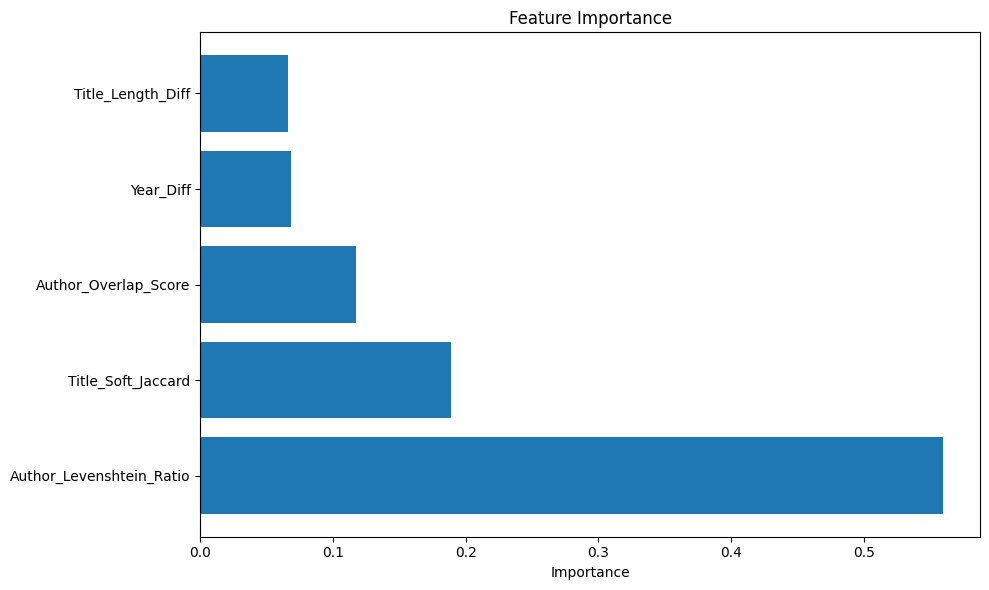

In [110]:
# Feature Importance
print("\nFeature Importance:")
importance_df = get_feature_importance(model, available_features)
display(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

## **Prediction**

### Goal
Run the trained ranking model to produce **Top-5 arXiv predictions** for each BibTeX entry on **test/validation/train** splits, then build the corresponding **ground-truth mappings** to support evaluation.

### Workflow
1. **Predict rankings for each dataset split**
   - Call `predict_rankings(model, df_*, available_features, top_k=5)` for:
     - `df_test` → `test_predictions`
     - `df_val` → `val_predictions`
     - `df_train` → `train_predictions`
   - Output format is a nested dictionary:
     - `{pub_id: {bib_key: [top_k_candidate_arxiv_ids]}}`

2. **Extract ground truth labels**
   - Convert each labeled DataFrame into ground-truth mappings using `extract_groundtruth(df_*)`:
     - `df_test` → `test_groundtruth`
     - `df_val` → `val_groundtruth`
     - `df_train` → `train_groundtruth`
   - Ground truth typically maps each publication (and its bib keys) to the correct arXiv ID(s).

3. **Print summary statistics**
   - For each split, print:
     - total number of ground-truth references extracted (sum of lengths)
     - number of publications represented in the ground-truth dict

In [111]:
# Predict on test set (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on test set...")
test_predictions = predict_rankings(model, df_test, available_features, top_k=5)

# Predict on validation set
print("Predicting on validation set...")
val_predictions = predict_rankings(model, df_val, available_features, top_k=5)

# Predict on train set
print("Predicting on train set...")
train_predictions = predict_rankings(model, df_train, available_features, top_k=5)

test_groundtruth = extract_groundtruth(df_test)
val_groundtruth = extract_groundtruth(df_val)
train_groundtruth = extract_groundtruth(df_train)

print(f"\nGroundtruth extracted:")
print(f"  Test: {sum(len(v) for v in test_groundtruth.values())} references across {len(test_groundtruth)} publications")
print(f"  Valid: {sum(len(v) for v in val_groundtruth.values())} references across {len(val_groundtruth)} publications")
print(f"  Train: {sum(len(v) for v in train_groundtruth.values())} references across {len(train_groundtruth)} publications")

Predicting on test set...
Predicting on validation set...
Predicting on train set...

Groundtruth extracted:
  Test: 51 references across 2 publications
  Valid: 128 references across 2 publications
  Train: 947 references across 11 publications


## **Evaluation**

### Goal
Convert nested prediction/ground-truth structures into a flat format suitable for evaluation, then compute **MRR (Mean Reciprocal Rank)** on the **test set**.

### Workflow
1. **Flatten predictions and ground truth**
   - Convert nested predictions (`test_predictions`) into a flat structure using `flatten_nested_dict(...)`.
   - Convert nested ground truth (`test_groundtruth`) into a flat structure using `flatten_groundtruth(...)`.
   - This makes both outputs align in a consistent key/value format for metric computation.

2. **Evaluate using MRR**
   - Compute MRR with:
     - `calculate_mrr(test_predictions_flat, test_groundtruth_flat)`
   - Print the final score as `Test MRR`.

In [112]:
# Flatten for evaluation
test_predictions_flat = flatten_nested_dict(test_predictions)
test_groundtruth_flat = flatten_groundtruth(test_groundtruth)

# Evaluate on test set
print("="*70)
print("Evaluating on TEST set")
print("="*70)
test_mrr = calculate_mrr(test_predictions_flat, test_groundtruth_flat)
print(f"  Test MRR: {test_mrr:.4f}")

Evaluating on TEST set
  Test MRR: 0.9026


## **Export pred.json files**

### Goal
Run the trained ranker on the **entire featured dataset** (train + validation + test), then export a standardized `pred.json` file **per publication** containing:
- which split the publication belongs to (`partition`)
- its ground truth labels (`groundtruth`)
- the model’s Top-K predictions (`prediction`)

### Workflow
1. **Load the full featured dataset**
   - Read `../src/featured_dataset.csv` into `df_all`.

2. **Collect publication IDs by split**
   - Build sets of `pub_id` from the already-created splits:
     - `train_pub_ids`, `val_pub_ids`, `test_pub_ids`

3. **Predict rankings for all records**
   - Call `predict_rankings(model, df_all, available_features, top_k=5)`
   - Output is nested: `{pub_id: {bib_key: [top_k_candidates]}}`

4. **Extract ground truth for all data**
   - Call `extract_groundtruth(df_all)` to get nested ground truth per publication.

5. **Export `pred.json` per publication**
   - For each `pub_id` in `all_predictions`:
     - Create output folder: `OUTPUT_DIR/<pub_id>/`
     - Determine the publication’s split using `get_partition(...)`
     - Build a JSON object:
       - `"partition"`: train/valid/test/unknown
       - `"groundtruth"`: `all_groundtruth.get(pub_id, {})`
       - `"prediction"`: model predictions for that pub
     - Save to `OUTPUT_DIR/<pub_id>/pred.json`
     - Update counters in `exported` by partition.

In [113]:
def get_partition(pub_id, test_pub_ids, val_pub_ids, train_pub_ids):
    """Determine which partition a publication belongs to"""
    if pub_id in test_pub_ids:
        return "test"
    elif pub_id in val_pub_ids:
        return "valid"
    elif pub_id in train_pub_ids:
        return "train"
    else:
        return "unknown"

In [114]:
# Load all data (Train, Valid and Test set) to predict
df_all = pd.read_csv("../src/featured_dataset.csv")

# Get pub_ids for each partition
train_pub_ids = set(df_train['pub_id'].unique())
val_pub_ids = set(df_val['pub_id'].unique())
test_pub_ids = set(df_test['pub_id'].unique())

# Predict rankings for ALL data (returns nested dict: {pub_id: {bib_key: [candidates]}})
print("Predicting on all data (Train, Valid and Test set)...")
all_predictions = predict_rankings(model, df_all, available_features, top_k=5)

# Extract groundtruth (nested dict: {pub_id: {bib_key: arxiv_id}})
all_groundtruth = extract_groundtruth(df_all)

# Export pred.json for each publication
exported = {"train": 0, "valid": 0, "test": 0, "unknown": 0}
for pub_id, predictions in all_predictions.items():
    pub_folder = Path(OUTPUT_DIR + "/" + pub_id)
    pub_folder.mkdir(parents=True, exist_ok=True)
    
    # Determine correct partition for this publication
    partition = get_partition(pub_id, test_pub_ids, val_pub_ids, train_pub_ids)
    
    # Build pred.json
    pred_json = {
        "partition": partition,
        "groundtruth": all_groundtruth.get(pub_id, {}),
        "prediction": predictions
    }
    
    # Export to file
    output_file = pub_folder / "pred.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(pred_json, f, indent=2, ensure_ascii=False)
    
    exported[partition] += 1

print(f"\n{'='*60}")
print(f"Export Complete")
print(f"{'='*60}")
print(f"  pred.json files exported:")
print(f"    - Train: {exported['train']}")
print(f"    - Valid: {exported['valid']}")
print(f"    - Test:  {exported['test']}")
print(f"  Output folder: {OUTPUT_DIR}/")

Predicting on all data (Train, Valid and Test set)...

Export Complete
  pred.json files exported:
    - Train: 11
    - Valid: 2
    - Test:  2
  Output folder: 23127453/
